In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
pwd()

'/Users/stella/Documents/03.proj/01.modeling/p_ocean_poc_01/code'

In [3]:
path='../data/t_frigga_weather_map_alert_250214.csv'

df=pd.read_csv(path, encoding='euc-kr')
print(df.head(2))

   device_datetime_kor device_serial        lat         lon  battery  \
0  2024-11-26 12:31:32      VC6M6034  36.218604  127.883799     80.0   
1  2024-11-28 19:12:18      VC6M6094  34.796662  128.045073     50.0   

   temperature  humidity  acc_orig   acc  accx  accy  accz  tiltx  tilty  \
0         11.8      60.0       1.5  1.51  -0.1  -1.5   0.1   -2.0  -85.4   
1         10.8      56.0       1.1  1.10   0.0  -1.1   0.0   -0.2  -88.4   

   tiltz     measure_data_kst  aws_station_id aws_station_name   aws_lat  \
0    4.2  2024-11-26 12:00:00             135              추풍령  36.22025   
1    1.6  2024-11-28 19:00:00             913              상주면  34.72380   

     aws_lon  distance_km  ws1  ws10   ta    hm  min_temp  max_temp  \
0  127.99458     9.962353  5.2   5.4  8.5  75.6      -5.5      21.3   
1  127.98155     9.957861  5.0   5.2  8.0  54.5       8.0      17.4   

   mean_temp  std_temp  min_humi  max_humi  mean_humi  std_humi  min_acc  \
0      12.81     51.36      32.0   

### DATA 전처리

#### 파손 정보에 대해 새로운 pivot으로 생성

In [4]:
# 2. device_serial별로 파손 여부를 집계하여 피벗 테이블 생성
df['item_shock'] = df['item_shock'].apply(lambda x: 1 if x == '파손' else 0)
shock_piv = df.groupby('device_serial')['item_shock'].sum().reset_index()
# 3. 파손 여부를 0 또는 1로 변환
shock_piv['item_shock'] = shock_piv['item_shock'].apply(lambda x: 1 if x > 0 else 0)
shock_piv.rename(columns={'item_shock': 'shock_YN'}, inplace=True)
print(shock_piv)

# shock_piv.to_csv('../item_shock_lst.csv', index=False)

    device_serial  shock_YN
0        VC6M6002         0
1        VC6M6003         1
2        VC6M6007         1
3        VC6M6008         0
4        VC6M600A         0
..            ...       ...
152      VC6M61C3         0
153      VC6M61C4         0
154      VC6M61ED         0
155      VC6ML002         1
156      VC6ML003         0

[157 rows x 2 columns]


Non-Broken    0.66879
Broken        0.33121
Name: proportion, dtype: float64


/var/folders/rn/92k08wkx2yd2fs07gw0zhx8r0000gn/T/ipykernel_60008/2277573526.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shock_piv_fin.index, y=shock_piv_fin.values, palette='pastel')


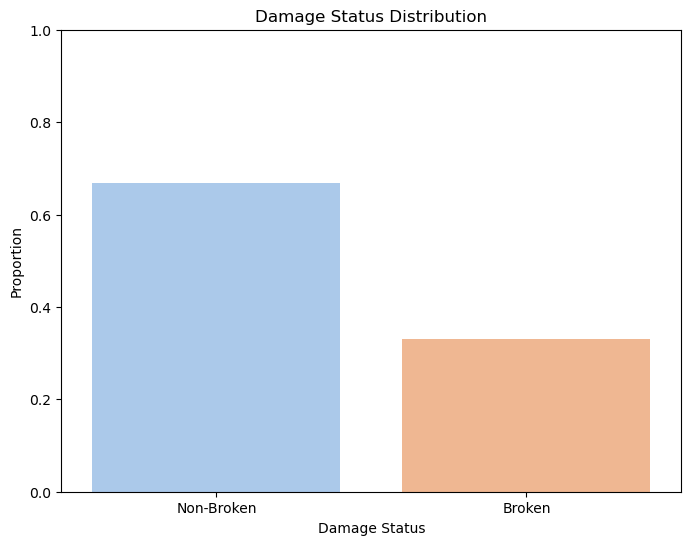

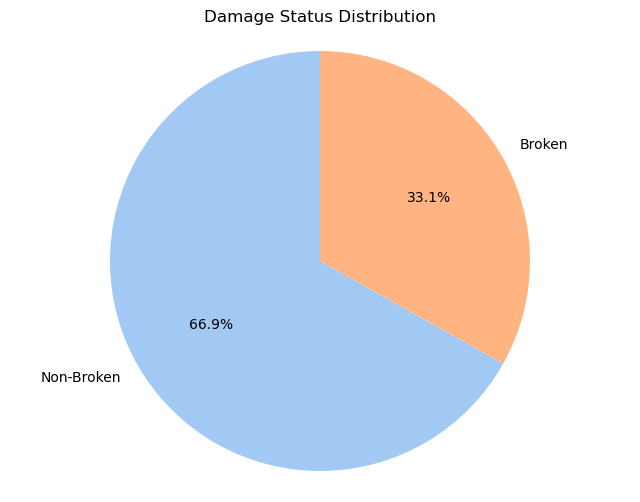

In [5]:
shock_piv_fin=shock_piv['shock_YN'].value_counts(normalize=True)  # 비율 계산
shock_piv_fin.index = ['Non-Broken', 'Broken']  # 인덱스 이름 변경
print(shock_piv_fin)

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=shock_piv_fin.index, y=shock_piv_fin.values, palette='pastel')
plt.title('Damage Status Distribution')
plt.xlabel('Damage Status')
plt.ylabel('Proportion')
plt.ylim(0, 1)  # Y축 범위를 0에서 1로 설정
plt.show()

# pie chart
plt.figure(figsize=(8, 6))
plt.pie(shock_piv_fin, labels=shock_piv_fin.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title('Damage Status Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()


#### alert_ 컬럼의 text 변경

In [6]:
# 일탈 상태를 이진 변수로 변환 (예: '정상'은 0, '일탈'은 1)
df['alert_temp'] = df['alert_temp'].apply(lambda x: 1 if x == '일탈' else 0)
df['alert_humi'] = df['alert_humi'].apply(lambda x: 1 if x == '일탈' else 0)
df['alert_acc'] = df['alert_acc'].apply(lambda x: 1 if x == '일탈' else 0)


#### 결측치 처리

In [7]:
# median ws1, ws10, ta, hm의 평균값 계산
median_values = df.groupby('device_serial')[['ws1', 'ws10', 'ta', 'hm']].median().reset_index()
median_values.rename(columns={'ws1': 'median_ws1', 'ws10': 'median_ws10', 'ta': 'median_ta', 'hm': 'median_hm'}, inplace=True)

In [8]:
# df와 median_values를 device_serial을 기준으로 병합
df = df.merge(median_values, on='device_serial', how='left')

In [9]:
# df.rename(columns={'ws1': 'median_ws1', 'ws10': 'median_ws10', 'ta': 'median_ta', 'hm': 'median_hm'}, inplace=True)
# 조건에 맞는 값 대체
df['ws1'] = df['ws1'].where(df['ws1'] > -50, df['median_ws1'])
df['ws10'] = df['ws10'].where(df['ws10'] > -50, df['median_ws10'])
df['ta'] = df['ta'].where(df['ta'] > -50, df['median_ta'])
df['hm'] = df['hm'].where(df['hm'] > -50, df['median_hm'])

### 기초통계

In [10]:
print(df.columns)
lst = ['device_datetime_kor', 'device_serial', 'lat', 'lon', 'battery', 'temperature', 'humidity', 'acc_orig', 'acc', 'accx', 'accy', 'accz',
       'tiltx', 'tilty', 'tiltz', 'measure_data_kst', 'aws_station_id', 'distance_km', 'ws1', 'ws10', 'ta', 'hm', 
       'min_temp', 'max_temp', 'mean_temp', 'std_temp', 'min_humi', 'max_humi', 'mean_humi', 'std_humi', 'min_acc', 'max_acc', 'mean_acc',
       'std_acc', 'q1_temp', 'q3_temp', 'temp_start', 'temp_end', 'q1_humi', 'q3_humi', 'humi_start', 'humi_end', 'q1_acc', 'q3_acc', 'acc_start',
       'acc_end', 'median_ws1', 'median_ws10', 'median_ta', 'median_hm', 'alert_temp', 'alert_humi', 'alert_acc', 'item_shock']

df_stat=df[lst].copy()

Index(['device_datetime_kor', 'device_serial', 'lat', 'lon', 'battery',
       'temperature', 'humidity', 'acc_orig', 'acc', 'accx', 'accy', 'accz',
       'tiltx', 'tilty', 'tiltz', 'measure_data_kst', 'aws_station_id',
       'aws_station_name', 'aws_lat', 'aws_lon', 'distance_km', 'ws1', 'ws10',
       'ta', 'hm', 'min_temp', 'max_temp', 'mean_temp', 'std_temp', 'min_humi',
       'max_humi', 'mean_humi', 'std_humi', 'min_acc', 'max_acc', 'mean_acc',
       'std_acc', 'q1_temp', 'q3_temp', 'temp_start', 'temp_end', 'q1_humi',
       'q3_humi', 'humi_start', 'humi_end', 'q1_acc', 'q3_acc', 'acc_start',
       'acc_end', 'alert_temp', 'alert_humi', 'alert_acc', 'item_shock',
       'median_ws1', 'median_ws10', 'median_ta', 'median_hm'],
      dtype='object')


In [11]:
print(df_stat.head(2))

   device_datetime_kor device_serial        lat         lon  battery  \
0  2024-11-26 12:31:32      VC6M6034  36.218604  127.883799     80.0   
1  2024-11-28 19:12:18      VC6M6094  34.796662  128.045073     50.0   

   temperature  humidity  acc_orig   acc  accx  accy  accz  tiltx  tilty  \
0         11.8      60.0       1.5  1.51  -0.1  -1.5   0.1   -2.0  -85.4   
1         10.8      56.0       1.1  1.10   0.0  -1.1   0.0   -0.2  -88.4   

   tiltz     measure_data_kst  aws_station_id  distance_km  ws1  ws10   ta  \
0    4.2  2024-11-26 12:00:00             135     9.962353  5.2   5.4  8.5   
1    1.6  2024-11-28 19:00:00             913     9.957861  5.0   5.2  8.0   

     hm  min_temp  max_temp  mean_temp  std_temp  min_humi  max_humi  \
0  75.6      -5.5      21.3      12.81     51.36      32.0      87.0   
1  54.5       8.0      17.4      11.55      3.97      49.0      65.0   

   mean_humi  std_humi  min_acc  max_acc  mean_acc  std_acc  q1_temp  q3_temp  \
0      53.29      8.7

### 통계분석

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

### device_serial 별로 파손 케이스 분석

In [13]:
df_stat

,device_datetime_kor,device_serial,lat,lon,battery,temperature,humidity,acc_orig,acc,accx,accy,accz,tiltx,tilty,tiltz,measure_data_kst,aws_station_id,distance_km,ws1,ws10,ta,hm,min_temp,max_temp,mean_temp,std_temp,min_humi,max_humi,mean_humi,std_humi,min_acc,max_acc,mean_acc,std_acc,q1_temp,q3_temp,temp_start,temp_end,q1_humi,q3_humi,humi_start,humi_end,q1_acc,q3_acc,acc_start,acc_end,median_ws1,median_ws10,median_ta,median_hm,alert_temp,alert_humi,alert_acc,item_shock
0,2024-11-26 12:31:32,VC6M6034,36.218604,127.883799,80.0,11.8,60.0,1.5,1.51,-0.1,-1.5,0.1,-2.0,-85.4,4.2,2024-11-26 12:00:00,135,9.962353,5.2,5.4,8.5,75.6,-5.5,21.3,12.81,51.36,32.0,87.0,53.29,8.78,0.88,1.81,1.16,0.10,7.50,20.10,-11.40,39.00,46.0,60.0,25.00,81.00,1.06,1.21,0.84,1.43,3.4,3.20,3.5,61.7,0,0,1,1
1,2024-11-28 19:12:18,VC6M6094,34.796662,128.045073,50.0,10.8,56.0,1.1,1.10,0.0,-1.1,0.0,-0.2,-88.4,1.6,2024-11-28 19:00:00,913,9.957861,5.0,5.2,8.0,54.5,8.0,17.4,11.55,3.97,49.0,65.0,60.04,2.64,1.10,1.50,1.14,0.08,10.15,12.50,6.62,16.03,59.0,62.0,54.50,66.50,1.10,1.10,1.10,1.10,2.7,2.90,9.4,58.6,0,0,0,0
2,2024-11-28 22:12:18,VC6M6094,34.633926,127.978666,50.0,10.2,58.0,1.1,1.10,0.0,-1.1,0.0,-0.6,-88.4,1.5,2024-11-28 22:00:00,913,9.973720,3.6,4.0,7.5,55.2,8.0,17.4,11.55,3.97,49.0,65.0,60.04,2.64,1.10,1.50,1.14,0.08,10.15,12.50,6.62,16.03,59.0,62.0,54.50,66.50,1.10,1.10,1.10,1.10,2.7,2.90,9.4,58.6,0,0,0,0
3,2024-11-28 04:14:10,VC6M60A2,34.634202,127.985764,40.0,8.1,56.0,1.1,1.10,0.0,-1.1,0.0,1.7,-87.0,2.5,2024-11-28 04:00:00,913,9.947099,3.4,2.6,4.7,64.7,7.8,16.0,11.60,6.13,51.0,66.0,57.08,3.23,1.00,1.40,1.09,0.08,10.05,14.30,3.68,20.68,54.5,59.0,47.75,65.75,1.00,1.10,0.85,1.25,3.4,3.00,8.6,60.2,0,0,0,0
4,2024-12-17 21:31:47,VC6M60AD,36.815106,127.061828,100.0,3.2,55.0,1.0,1.01,0.1,0.1,1.0,2.5,3.5,-85.7,2024-12-17 21:00:00,493,9.991122,2.4,2.6,1.1,67.2,-2.2,25.2,21.57,14.25,12.0,56.0,20.47,5.32,1.00,1.44,1.00,0.02,21.20,23.20,18.20,26.20,17.0,23.0,8.00,32.00,1.00,1.00,1.00,1.00,1.9,1.90,-1.9,69.6,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146523,2024-11-29 11:50:50,VC6M6049,36.300355,127.595394,90.0,3.4,65.0,1.2,1.20,0.0,-1.2,0.0,-1.7,-88.2,-0.7,2024-11-29 11:00:00,604,0.112317,2.2,1.9,3.4,63.3,-1.8,12.6,3.19,8.66,58.0,72.0,65.74,2.03,1.00,1.60,1.02,0.06,1.80,3.53,-0.79,6.11,65.0,67.0,62.00,70.00,1.00,1.00,1.00,1.00,2.4,2.10,1.6,91.9,0,0,1,0
146524,2024-12-02 15:36:09,VC6M60C1,36.298510,127.597675,100.0,17.3,55.0,1.2,1.20,-0.1,-1.2,0.0,-0.6,-88.6,1.2,2024-12-02 15:00:00,604,0.189542,2.9,3.1,15.9,42.9,2.2,19.2,10.38,14.98,48.0,66.0,58.20,3.10,1.00,1.56,1.01,0.04,7.00,14.10,-3.65,24.75,56.0,60.0,50.00,66.00,1.00,1.00,1.00,1.00,3.1,3.10,6.0,45.8,0,0,1,0
146525,2024-12-13 12:51:44,VC6M60E6,36.299017,127.593702,100.0,5.1,40.0,1.0,1.00,0.0,-1.0,0.0,-1.9,-87.9,0.9,2024-12-13 12:00:00,604,0.275135,1.7,0.8,3.6,34.2,0.6,8.1,6.57,2.25,37.0,49.0,44.63,2.98,1.00,1.30,1.02,0.06,6.55,7.35,5.35,8.55,43.0,48.0,35.50,55.50,1.00,1.00,1.00,1.00,3.1,3.00,5.4,42.5,1,0,0,0
146526,2024-12-13 13:01:44,VC6M60E6,36.299017,127.593702,100.0,5.1,40.0,1.1,1.10,0.0,-1.1,0.0,0.0,-87.8,-2.2,2024-12-13 13:00:00,604,0.275135,1.7,1.6,3.6,36.7,0.6,8.1,6.57,2.25,37.0,49.0,44.63,2.98,1.00,1.30,1.02,0.06,6.55,7.35,5.35,8.55,43.0,48.0,35.50,55.50,1.00,1.00,1.00,1.00,3.1,3.00,5.4,42.5,1,0,1,0


#### (계절)측정 날짜의 Month, Seanson을 기반으로 정리

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
# 1. 임의의 10개 device_serial 추출
spl_d = df_stat['device_serial'].sample(n=10, random_state=42).tolist()
spl_data = df_stat[df_stat['device_serial'].isin(spl_d)]
spl_data

,device_datetime_kor,device_serial,lat,lon,battery,temperature,humidity,acc_orig,acc,accx,accy,accz,tiltx,tilty,tiltz,measure_data_kst,aws_station_id,distance_km,ws1,ws10,ta,hm,min_temp,max_temp,mean_temp,std_temp,min_humi,max_humi,mean_humi,std_humi,min_acc,max_acc,mean_acc,std_acc,q1_temp,q3_temp,temp_start,temp_end,q1_humi,q3_humi,humi_start,humi_end,q1_acc,q3_acc,acc_start,acc_end,median_ws1,median_ws10,median_ta,median_hm,alert_temp,alert_humi,alert_acc,item_shock
133,2024-11-26 15:51:02,VC6M6090,36.915377,127.010615,100.0,12.5,39.0,1.3,1.30,0.0,-1.3,0.0,2.9,-85.0,4.1,2024-11-26 15:00:00,358,9.809940,2.4,4.8,4.8,78.6,-9.7,14.4,0.92,12.72,35.0,75.0,56.09,5.39,0.96,1.40,1.08,0.06,-0.9,3.0,-6.75,8.85,53.0,59.0,44.0,68.0,1.03,1.10,0.92,1.20,1.7,1.8,-0.9,70.9,1,1,1,정상
241,2024-11-26 16:01:02,VC6M6090,36.915377,127.010615,100.0,11.7,41.0,1.4,1.40,-0.1,-1.4,0.0,-1.1,-87.5,2.3,2024-11-26 16:00:00,358,9.809940,3.1,0.6,6.6,68.4,-9.7,14.4,0.92,12.72,35.0,75.0,56.09,5.39,0.96,1.40,1.08,0.06,-0.9,3.0,-6.75,8.85,53.0,59.0,44.0,68.0,1.03,1.10,0.92,1.20,1.7,1.8,-0.9,70.9,1,1,1,정상
4580,2025-01-04 22:27:35,VC6M6038,36.814052,127.054717,40.0,-0.8,50.0,1.0,1.02,-0.2,1.0,0.1,-13.8,75.3,-4.8,2025-01-04 22:00:00,493,9.596580,1.4,1.0,-3.6,79.5,-10.8,10.2,0.39,12.87,40.0,91.0,58.65,7.66,0.93,5.33,1.01,0.08,-1.7,2.8,-8.45,9.55,53.0,64.0,36.5,80.5,1.00,1.01,0.98,1.02,1.9,1.9,-1.4,71.6,0,0,0,정상
4581,2025-01-04 22:47:35,VC6M6038,36.814052,127.054717,40.0,-1.1,50.0,1.0,1.02,-0.2,1.0,0.1,-13.9,75.3,-4.8,2025-01-04 22:00:00,493,9.596580,1.4,1.0,-3.6,79.5,-10.8,10.2,0.39,12.87,40.0,91.0,58.65,7.66,0.93,5.33,1.01,0.08,-1.7,2.8,-8.45,9.55,53.0,64.0,36.5,80.5,1.00,1.01,0.98,1.02,1.9,1.9,-1.4,71.6,0,0,0,정상
4582,2025-01-04 23:07:35,VC6M6038,36.814052,127.054717,40.0,-1.3,51.0,1.0,1.02,-0.2,1.0,0.1,-13.8,75.4,-4.7,2025-01-04 23:00:00,493,9.596580,1.8,1.3,-3.9,82.6,-10.8,10.2,0.39,12.87,40.0,91.0,58.65,7.66,0.93,5.33,1.01,0.08,-1.7,2.8,-8.45,9.55,53.0,64.0,36.5,80.5,1.00,1.01,0.98,1.02,1.9,1.9,-1.4,71.6,0,0,0,정상
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144687,2024-12-05 08:19:33,VC6M60C0,35.111292,129.102970,80.0,4.9,66.0,1.0,1.00,-0.1,-1.0,0.0,-5.7,-84.3,-0.3,2024-12-05 08:00:00,942,1.557069,1.2,1.3,5.0,59.8,-10.8,16.0,1.54,18.79,40.0,94.0,61.35,9.00,0.87,2.60,0.96,0.06,-1.1,3.8,-8.45,11.15,55.0,66.0,38.5,82.5,0.93,1.00,0.83,1.10,1.9,2.0,-0.2,70.9,0,0,0,정상
144688,2024-12-05 08:29:33,VC6M60C0,35.111292,129.102970,80.0,5.4,65.0,1.0,1.00,-0.1,-1.0,0.0,-5.3,-84.6,0.6,2024-12-05 08:00:00,942,1.557069,1.2,1.3,5.0,59.8,-10.8,16.0,1.54,18.79,40.0,94.0,61.35,9.00,0.87,2.60,0.96,0.06,-1.1,3.8,-8.45,11.15,55.0,66.0,38.5,82.5,0.93,1.00,0.83,1.10,1.9,2.0,-0.2,70.9,0,0,0,정상
144689,2024-12-05 08:39:33,VC6M60C0,35.111292,129.102970,80.0,5.4,65.0,1.1,1.10,-0.1,-1.1,0.0,-5.9,-84.1,-0.3,2024-12-05 08:00:00,942,1.557069,1.2,1.3,5.0,59.8,-10.8,16.0,1.54,18.79,40.0,94.0,61.35,9.00,0.87,2.60,0.96,0.06,-1.1,3.8,-8.45,11.15,55.0,66.0,38.5,82.5,0.93,1.00,0.83,1.10,1.9,2.0,-0.2,70.9,0,0,0,정상
146098,2024-12-05 09:29:33,VC6M60C0,35.110660,129.093324,80.0,6.4,63.0,1.2,1.24,-0.3,-1.2,0.0,-4.8,-84.9,1.8,2024-12-05 09:00:00,942,0.991218,2.9,1.7,6.7,57.4,-10.8,16.0,1.54,18.79,40.0,94.0,61.35,9.00,0.87,2.60,0.96,0.06,-1.1,3.8,-8.45,11.15,55.0,66.0,38.5,82.5,0.93,1.00,0.83,1.10,1.9,2.0,-0.2,70.9,0,0,1,정상


In [23]:
spl_data.groupby('device_serial').size()

device_serial
VC6M6007    3919
VC6M6038    2993
VC6M603C    1253
VC6M6074    1157
VC6M6090    3794
VC6M60A5    1974
VC6M60AC    1881
VC6M60C0    3738
VC6M60D7    1713
dtype: int64

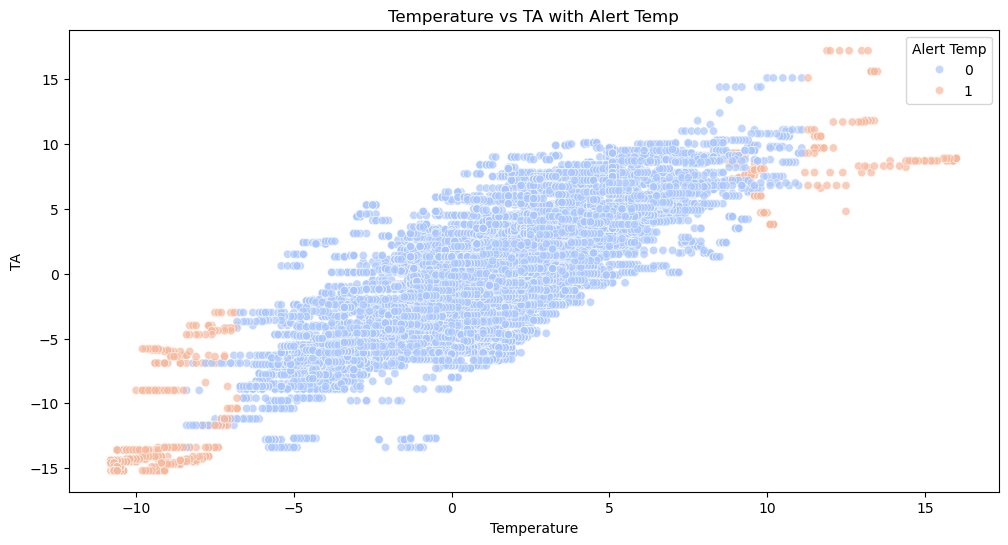

In [25]:
# 2. temperature와 ta 간의 상관관계에 따른 alert_temp 관계 분석
plt.figure(figsize=(12, 6))
sns.scatterplot(x='temperature', y='ta', hue='alert_temp', data=spl_data, palette='coolwarm', alpha=0.7)
plt.title('Temperature vs TA with Alert Temp')
plt.xlabel('Temperature')
plt.ylabel('TA')
plt.legend(title='Alert Temp')
plt.show()

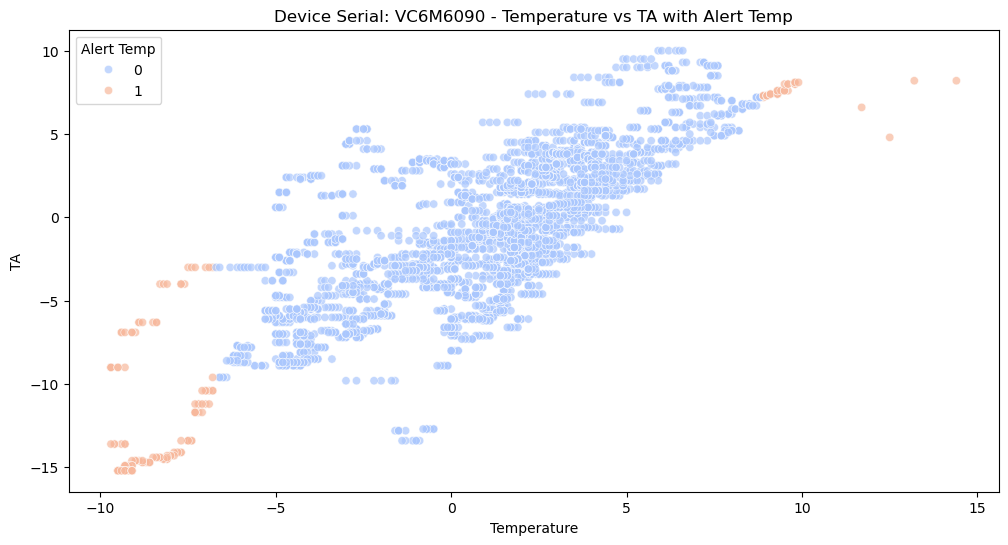

Device Serial: VC6M6090 - Temperature와 TA 간의 상관관계: 0.79


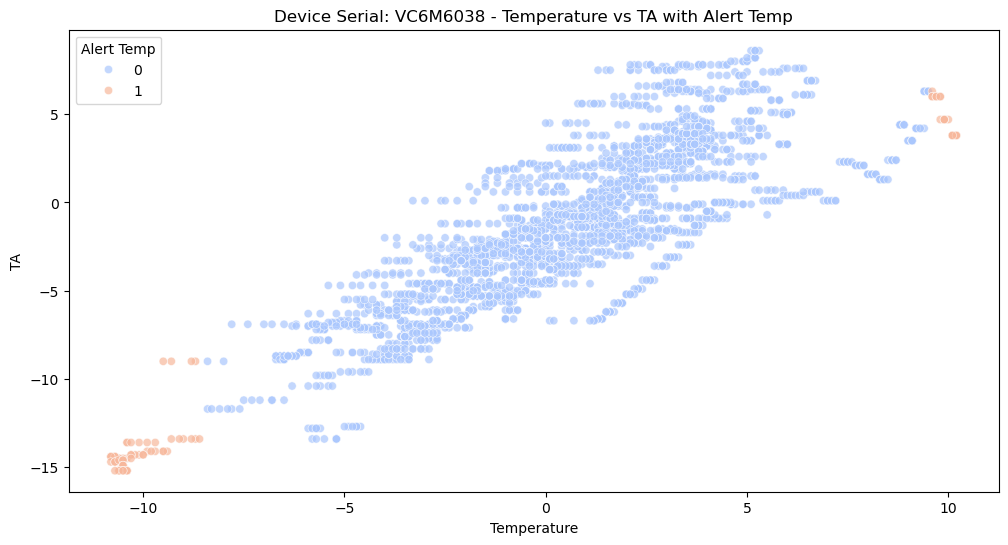

Device Serial: VC6M6038 - Temperature와 TA 간의 상관관계: 0.86


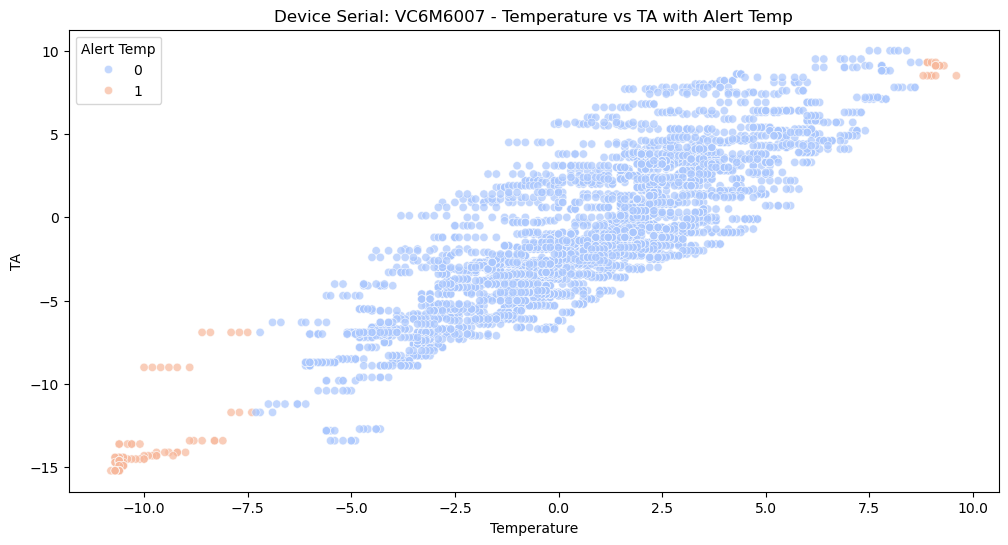

Device Serial: VC6M6007 - Temperature와 TA 간의 상관관계: 0.87


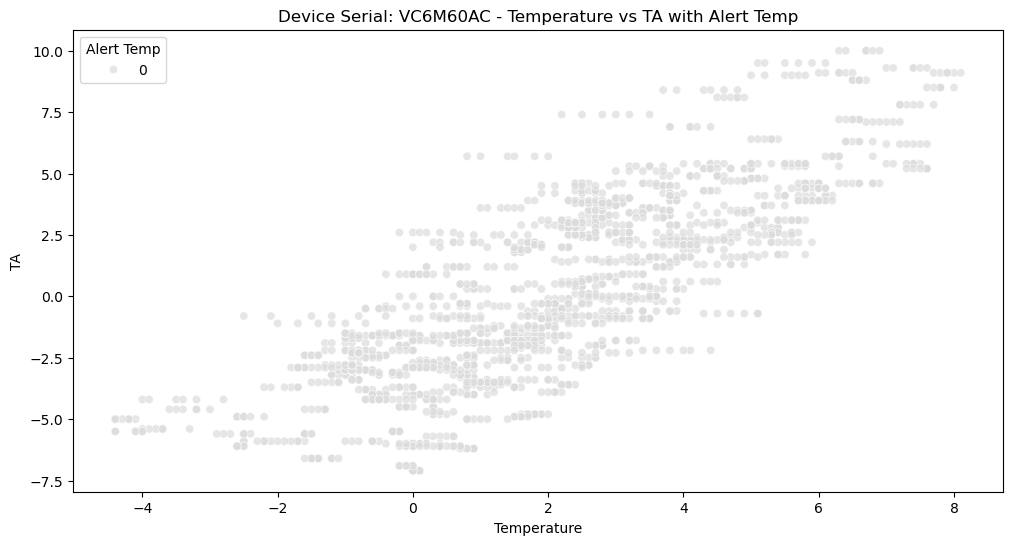

Device Serial: VC6M60AC - Temperature와 TA 간의 상관관계: 0.81


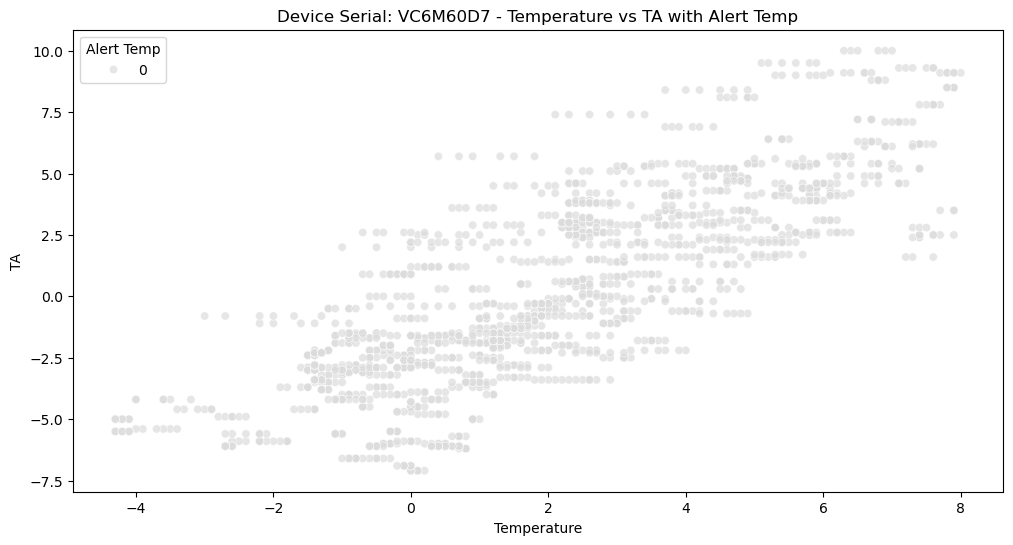

Device Serial: VC6M60D7 - Temperature와 TA 간의 상관관계: 0.80


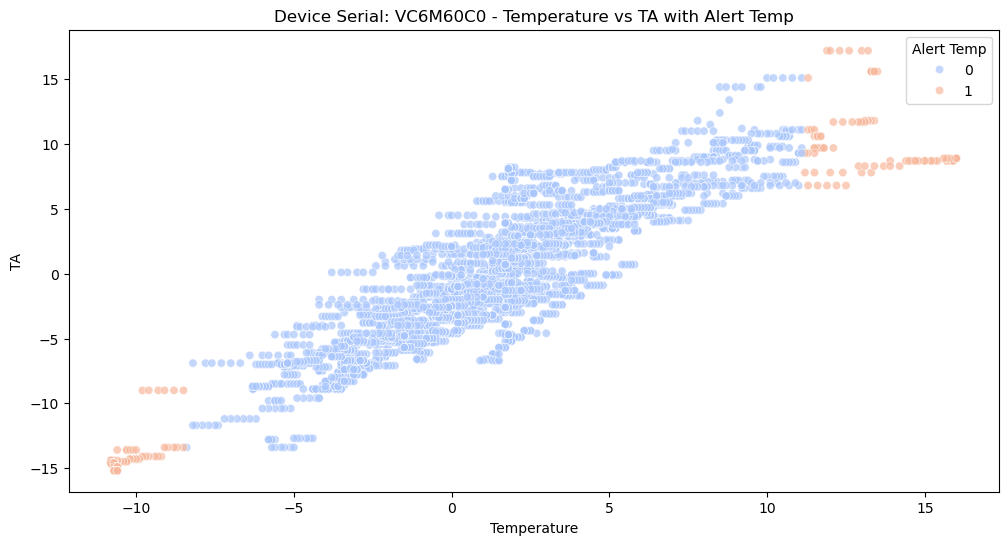

Device Serial: VC6M60C0 - Temperature와 TA 간의 상관관계: 0.90


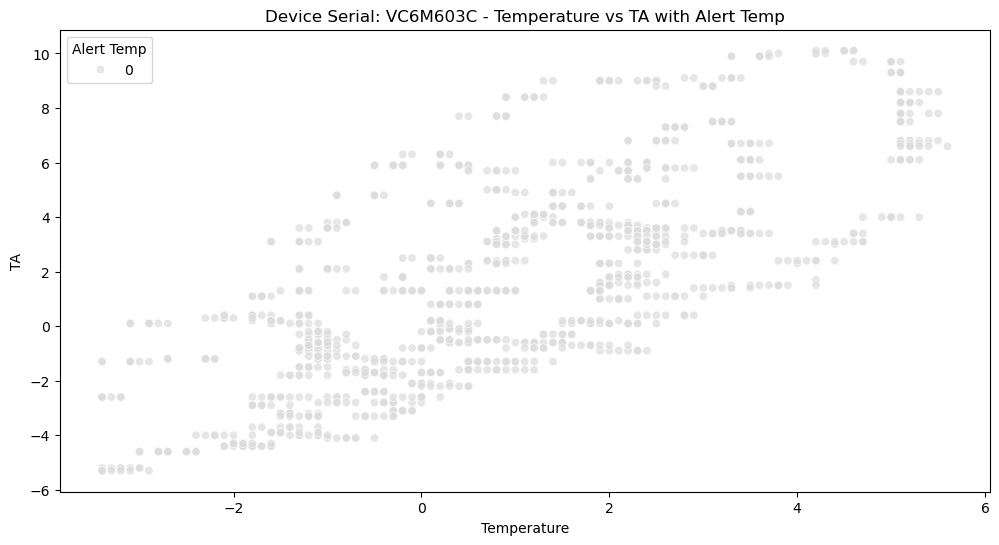

Device Serial: VC6M603C - Temperature와 TA 간의 상관관계: 0.74


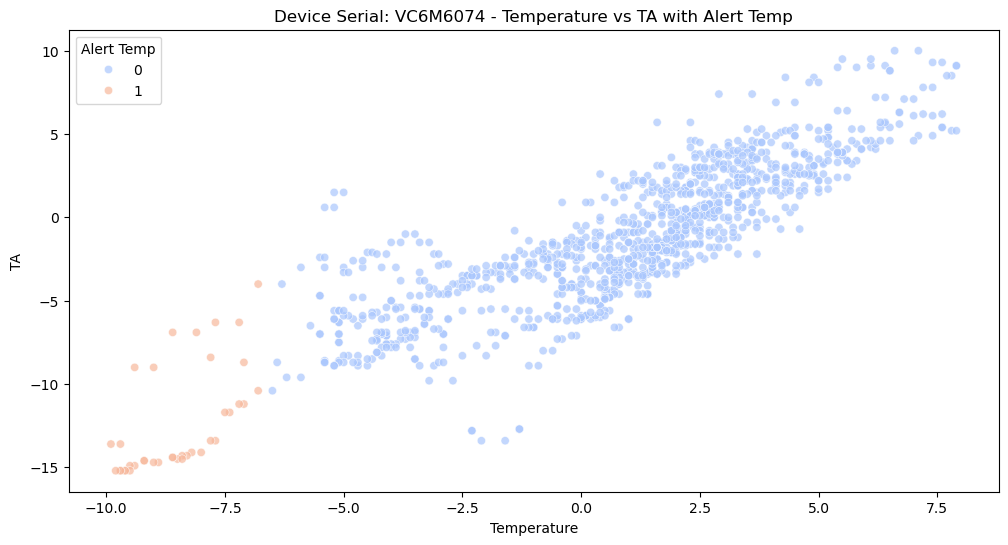

Device Serial: VC6M6074 - Temperature와 TA 간의 상관관계: 0.86


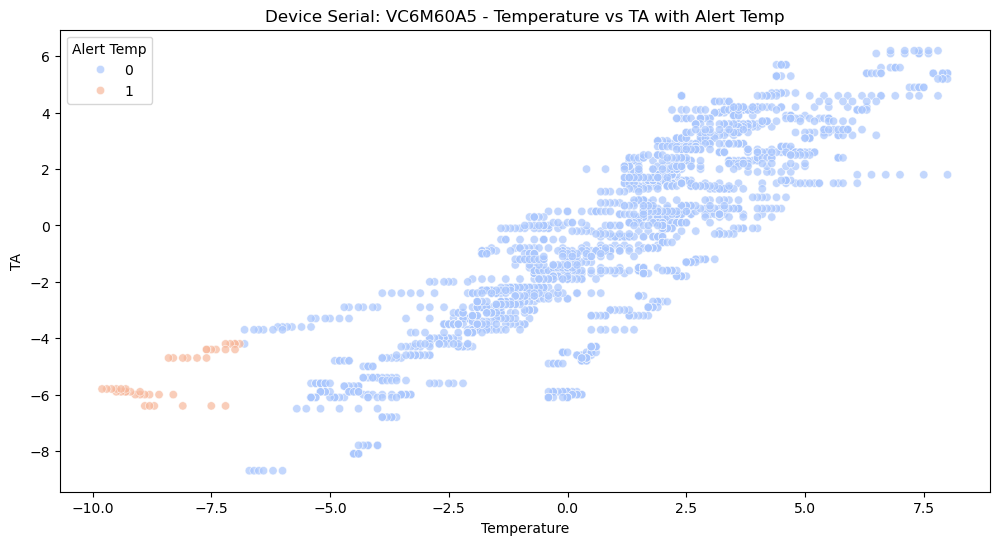

Device Serial: VC6M60A5 - Temperature와 TA 간의 상관관계: 0.86


In [27]:
# 2. device_serial별로 분석 수행
for device in spl_data['device_serial'].unique():
    device_data = spl_data[spl_data['device_serial'] == device]

    # 2.1 temperature와 ta 간의 상관관계에 따른 alert_temp 관계 분석
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='temperature', y='ta', hue='alert_temp', data=device_data, palette='coolwarm', alpha=0.7)
    plt.title(f'Device Serial: {device} - Temperature vs TA with Alert Temp')
    plt.xlabel('Temperature')
    plt.ylabel('TA')
    plt.legend(title='Alert Temp')
    plt.show()

    # 상관관계 계산
    temperature_ta_corr = device_data[['temperature', 'ta']].corr().iloc[0, 1]
    print(f'Device Serial: {device} - Temperature와 TA 간의 상관관계: {temperature_ta_corr:.2f}')